In [1]:
import haversine as hs
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
import geopandas as gpd
import xarray as xr
import torch
from torch_geometric.data import Data, Dataset
from Trainer import Trainer
from wind_utils import get_distance, draw_graph, nearest_neighbors_graph, plot_heatmap, dataset_generation
from GCN_Regression import GCN_RegressionModel

data = xr.open_dataset("data/delhi_cpcb_2022.nc")
# data = xr.open_dataset("delhi_cpcb_2022.nc")
data

<xarray.Dataset>
Dimensions:    (station: 40, time: 8783)
Coordinates:
  * station    (station) object 'Alipur, Delhi - DPCC' ... 'Wazirpur, Delhi -...
  * time       (time) datetime64[ns] 2022-01-01T00:30:00 ... 2023-01-01T22:23:30
    latitude   (station) float64 ...
    longitude  (station) float64 ...
Data variables: (12/21)
    From Date  (station, time) datetime64[ns] ...
    To Date    (station, time) datetime64[ns] ...
    PM2.5      (station, time) float64 ...
    PM10       (station, time) float64 ...
    NO         (station, time) float64 ...
    NO2        (station, time) float64 ...
    ...         ...
    WD         (station, time) float64 ...
    SR         (station, time) float64 ...
    BP         (station, time) float64 ...
    AT         (station, time) float64 ...
    RF         (station, time) float64 ...
    TOT-RF     (station, time) float64 ...

In [2]:
lat_list = [28.815329,28.647622,28.695381,28.4706914,28.7762,28.7256504,28.5512005,28.656756,28.7500499,28.498571,28.5710274,28.655935,28.5627763,28.6811736,28.628624,28.73282,28.58028,28.588333,28.5918245,28.611281,28.636429,28.684678,28.60909,28.570173,28.822836,28.56789,28.6573814,28.530785,28.623763,28.674045,28.639645,28.639645,28.563262,28.732528,28.6514781,28.5504249,28.710508,28.531346,28.672342,28.699793]

In [3]:
df = data.to_dataframe().reset_index()
wind_data = pd.read_csv('data/wind_temp_shifted.csv')

In [4]:
df = df.dropna(subset = ['PM2.5'])
df = df[df["time"]=="2022-03-01 01:30:00"]
wind_data = wind_data[wind_data['time'] == "2022-03-01 01:30:00"]

In [5]:
df.head()

,station,time,From Date,To Date,PM2.5,PM10,NO,NO2,NOx,NH3,...,RH,WS,WD,SR,BP,AT,RF,TOT-RF,latitude,longitude
1417,"Alipur, Delhi - DPCC",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,70.00,150.0,3.78,43.38,26.15,3.42,...,78.22,NaN,139.97,4.55,993.40,11.43,0.0,0.0,28.815329,77.153010
10200,"Anand Vihar, Delhi - DPCC",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,52.50,144.0,11.88,30.62,26.02,15.82,...,68.95,0.30,246.25,8.95,973.65,15.45,NaN,0.0,28.647622,77.315809
18983,"Ashok Vihar, Delhi - DPCC",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,79.00,134.0,7.47,67.17,41.80,50.77,...,71.30,0.38,206.90,5.43,987.17,13.82,0.0,0.0,28.695381,77.181665
27766,"Aya Nagar, Delhi - IMD",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,73.94,159.3,22.49,26.28,48.80,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,28.470691,77.109936
36549,"Bawana, Delhi - DPCC",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,135.00,245.0,4.80,20.65,25.43,41.45,...,81.62,0.62,22.33,5.70,993.12,12.30,0.0,0.0,28.776200,77.051074


In [6]:
wind_data

,Unnamed: 0,longitude,latitude,time,t,u,v
1417,1417,76.800003,28.90,2022-03-01 01:30:00,259.201813,41.675766,1.950005
10177,10177,76.800003,28.65,2022-03-01 01:30:00,258.615967,42.539955,2.665592
18937,18937,76.800003,28.40,2022-03-01 01:30:00,258.023010,43.372360,3.198282
27697,27697,77.050003,28.90,2022-03-01 01:30:00,259.554993,41.433395,1.890563
36457,36457,77.050003,28.65,2022-03-01 01:30:00,258.939209,42.551880,2.736465
45217,45217,77.050003,28.40,2022-03-01 01:30:00,258.315552,43.493546,3.332026
53977,53977,77.300003,28.90,2022-03-01 01:30:00,259.860931,41.161224,1.762535
62737,62737,77.300003,28.65,2022-03-01 01:30:00,259.252228,42.385002,2.653018
71497,71497,77.300003,28.40,2022-03-01 01:30:00,258.624237,43.555138,3.396040


In [7]:
df['WS'] = wind_data['u'].mean()
df['WD'] = wind_data['v'].mean()

In [8]:
df.head()

,station,time,From Date,To Date,PM2.5,PM10,NO,NO2,NOx,NH3,...,RH,WS,WD,SR,BP,AT,RF,TOT-RF,latitude,longitude
1417,"Alipur, Delhi - DPCC",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,70.00,150.0,3.78,43.38,26.15,3.42,...,78.22,42.463141,2.620503,4.55,993.40,11.43,0.0,0.0,28.815329,77.153010
10200,"Anand Vihar, Delhi - DPCC",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,52.50,144.0,11.88,30.62,26.02,15.82,...,68.95,42.463141,2.620503,8.95,973.65,15.45,NaN,0.0,28.647622,77.315809
18983,"Ashok Vihar, Delhi - DPCC",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,79.00,134.0,7.47,67.17,41.80,50.77,...,71.30,42.463141,2.620503,5.43,987.17,13.82,0.0,0.0,28.695381,77.181665
27766,"Aya Nagar, Delhi - IMD",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,73.94,159.3,22.49,26.28,48.80,NaN,...,NaN,42.463141,2.620503,NaN,NaN,NaN,NaN,0.0,28.470691,77.109936
36549,"Bawana, Delhi - DPCC",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,135.00,245.0,4.80,20.65,25.43,41.45,...,81.62,42.463141,2.620503,5.70,993.12,12.30,0.0,0.0,28.776200,77.051074


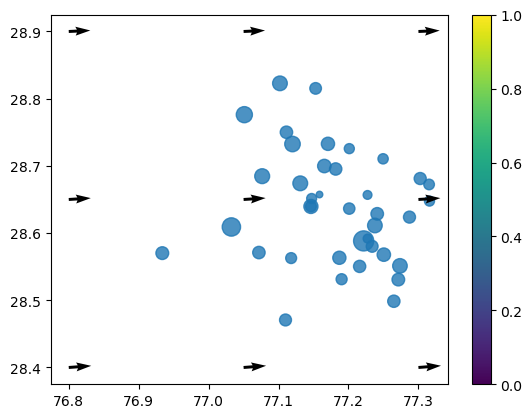

In [9]:
plt.scatter(df['longitude'], df['latitude'], s = df['PM2.5'], alpha = 0.8, label = 'PM2.5')
plt.quiver(wind_data['longitude'], wind_data['latitude'], wind_data['u'], wind_data['v'], label = 'Wind')
plt.colorbar()

In [10]:
G = nearest_neighbors_graph(df, 15)

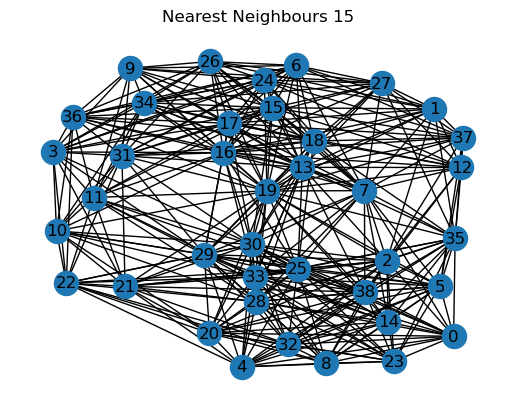

In [11]:
draw_graph(G, "Nearest Neighbours 15")

In [12]:
node_features, edge_index, y = dataset_generation(G)

In [13]:
train_mask = torch.zeros(y.size(0), dtype=torch.bool)
test_mask = torch.zeros(y.size(0), dtype=torch.bool)

for i, node in enumerate(G.nodes):
    lat = G.nodes[node]['latitude']
    if lat in lat_list[:25]:
        train_mask[i] = True
    else:
        test_mask[i] = True


data = Data(x=torch.tensor(node_features, dtype=torch.float), edge_index=edge_index, y=y,train_mask=train_mask, test_mask = test_mask)

In [14]:
data.is_directed()

False

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN_RegressionModel(4)

In [16]:
from torch_geometric.explain import Explainer, GNNExplainer
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='node',
        return_type='raw',
    ),
)
node_index = 10
explanation = explainer(data.x, data.edge_index, index=node_index)
print(f'Generated explanations in {explanation.available_explanations}')

path = 'feature_importance.png'
explanation.visualize_feature_importance(path, top_k=10)
print(f"Feature importance plot has been saved to '{path}'")

path = 'subgraph.pdf'
explanation.visualize_graph(path, backend="graphviz")
print(f"Subgraph visualization plot has been saved to '{path}'")

Generated explanations in ['node_mask', 'edge_mask']
Feature importance plot has been saved to 'feature_importance.png'
Subgraph visualization plot has been saved to 'subgraph.pdf'


In [17]:
G = explanation.get_explanation_subgraph()
G.visualize_graph()

In [18]:
trainer = Trainer(model = model, data = data, device = device, epochs=2500)
trainer.train(lr=0.001)

Epoch 0: Train RMSE 106.5644, Test RMSE 91.2261
Epoch 100: Train RMSE 97.2649, Test RMSE 81.4198
Epoch 200: Train RMSE 97.1745, Test RMSE 81.3262
Epoch 300: Train RMSE 97.0836, Test RMSE 81.2322
Epoch 400: Train RMSE 96.9926, Test RMSE 81.1380
Epoch 500: Train RMSE 96.9016, Test RMSE 81.0438
Epoch 600: Train RMSE 96.8105, Test RMSE 80.9495
Epoch 700: Train RMSE 96.7194, Test RMSE 80.8552
Epoch 800: Train RMSE 96.6283, Test RMSE 80.7609
Epoch 900: Train RMSE 96.5373, Test RMSE 80.6667
Epoch 1000: Train RMSE 96.4463, Test RMSE 80.5725
Epoch 1100: Train RMSE 96.3553, Test RMSE 80.4783
Epoch 1200: Train RMSE 96.2643, Test RMSE 80.3841
Epoch 1300: Train RMSE 96.1734, Test RMSE 80.2900
Epoch 1400: Train RMSE 96.0826, Test RMSE 80.1959
Epoch 1500: Train RMSE 95.9917, Test RMSE 80.1019
Epoch 1600: Train RMSE 95.9009, Test RMSE 80.0079
Epoch 1700: Train RMSE 95.8102, Test RMSE 79.9139
Epoch 1800: Train RMSE 95.7195, Test RMSE 79.8199
Epoch 1900: Train RMSE 95.6288, Test RMSE 79.7260
Epoch 2000:

In [19]:
from torch_geometric.nn import GINConv, global_add_pool
from torch_geometric.explain import Explainer, GNNExplainer,PGExplainer, CaptumExplainer
from torch_geometric.loader import DataLoader

In [20]:
loader = DataLoader(data, batch_size=1, shuffle=True)

In [21]:
explanation.visualize_graph()

In [22]:
out = model(data.x.to(device), data.edge_index.to(device))  # Predicted PM values
test_rmse = torch.sqrt(torch.mean((out[data.test_mask].squeeze() - data.y[data.test_mask].squeeze())**2))

In [23]:
test_rmse.detach()

tensor(79.1641)

In [24]:
latitudes = np.array(df['latitude'])
longitudes = np.array(df['longitude'])
g_lat = np.linspace(latitudes.min()-0.1, latitudes.max()+0.1, 30)
g_long = np.linspace(longitudes.min()-0.1, longitudes.max()+0.1, 30)
lat_grid, lon_grid = np.meshgrid(g_lat, g_long)

u_ = df['WS'].mean()
v_ = df['WD'].mean()
test_ws = [u_]*len(lon_grid.flatten())
test_wd = [v_]*len(lon_grid.flatten())

train = df[['latitude', 'longitude', 'PM2.5', 'WS', 'WD']]
test = pd.DataFrame({'longitude':lon_grid.flatten(),
                     'latitude':lat_grid.flatten(),
                     'WS':test_ws, 
                     'WD':test_wd})

In [25]:
Gh = nx.Graph()

# Iterate over each row in the dataframe
for i in range(len(test)):
    lat1, lon1 = test.iloc[i]["latitude"], test.iloc[i]["longitude"]
    ws = test.iloc[i]['WS']
    wd = test.iloc[i]['WD']

    # Add a node to the graph with latitude, longitude, PM2.5, and station attributes
    Gh.add_node(i, latitude=lat1, longitude=lon1, ws = ws, wd = wd)

    # Iterate over the remaining rows to check for edges
    for j in range(i + 1, len(test)):
        lat2, lon2 = test.iloc[j]["latitude"], test.iloc[j]["longitude"]

        # Calculate the distance between the two nodes
        distance = get_distance(lat1, lon1, lat2, lon2)

        # Check if the distance is within the threshold
        if distance <= 12:
            # Add an edge between the nodes
            Gh.add_edge(i, j)

In [26]:
node_features = [(Gh.nodes[node]['latitude'], Gh.nodes[node]['longitude'], Gh.nodes[node]['ws'], Gh.nodes[node]['wd']) for node in Gh.nodes]
edge_index = torch.tensor(list(Gh.edges)).t().contiguous()

data_h = Data(x=torch.tensor(node_features, dtype=torch.float), edge_index=edge_index)

In [27]:
out = model(data_h.x.to(device), data_h.edge_index.to(device))
test['PM2.5'] = out.detach().numpy()

In [28]:
def heatmap(df, latitudes, longitudes, values):

    # Read shapefile data
    delhi_shapefile = gpd.read_file('data/Delhi/Districts.shp')

    # Create GeoDataFrame from dataframe and points
    gdf_data = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

    # Define grid for contour plot
    g_lat = np.linspace(latitudes.min() - 0.1, latitudes.max() + 0.1, 30)
    g_long = np.linspace(longitudes.min() - 0.1, longitudes.max() + 0.1, 30)
    lat_grid, lon_grid = np.meshgrid(g_lat, g_long)

    # Create temporary GeoDataFrame for grid points
    temp_data = gpd.GeoDataFrame(geometry=gpd.points_from_xy(lon_grid.flatten(), lat_grid.flatten()))

    # Read shapefile data
    delhi_shapefile = gpd.read_file('data/Delhi/Districts.shp')
    shapefile_extent = delhi_shapefile.total_bounds

    # Create figure and axes
    fig, ax = plt.subplots(figsize=(10, 10))

    # Calculate vmin and vmax based on percentiles
    vmin = np.percentile(values, 2)
    vmax = np.percentile(values, 98)

    # Create contour plot
    contour = ax.contourf(longitudes.reshape(lon_grid.shape), latitudes.reshape(lon_grid.shape), values.reshape(lon_grid.shape),
                          cmap='coolwarm', levels=200, vmin=vmin, vmax=vmax)

    # Plot shapefile boundaries
    delhi_shapefile.plot(ax=ax, edgecolor='black', facecolor='none')

    # Plot data points as black markers
    gdf_data.plot(ax=ax, color='black', markersize=20, label='Air Stations')

    # Plot data points as colored bubbles
    scatter = ax.scatter(df['longitude'], df['latitude'], s=df["PM2.5"], c=df["PM2.5"])
    
    u1 = df['WS']
    v1 = df['WD']
    u1_ = u1.sum()
    v1_ = v1.sum()
    
#     ax.text(0.02, 0.02, "Net Wind")
      
    quiver = ax.quiver(df['longitude'], df['latitude'], u1, v1, alpha = 0.5, label = 'Wind')
#     overall_quiver = ax.quiver(76.9, 28.85, u1_, v1_)
#     plt.text(76.87, 28.88, "Overall Wind")
    
    # Add colorbars
    cbar1 = plt.colorbar(contour, label='PM2.5 - for contour plot', shrink=0.7)
    cbar2 = plt.colorbar(scatter, label='PM2.5 - for bubble plot', shrink=0.7)
    cbar1.ax.set_ylabel('PM2.5')
    cbar2.ax.set_ylabel('PM2.5')

    # Set x-axis and y-axis labels
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Set title and legend
    plt.title('PM2.5 Predictions Heatmap')
    plt.legend()

    # Display the plot
    plt.show()

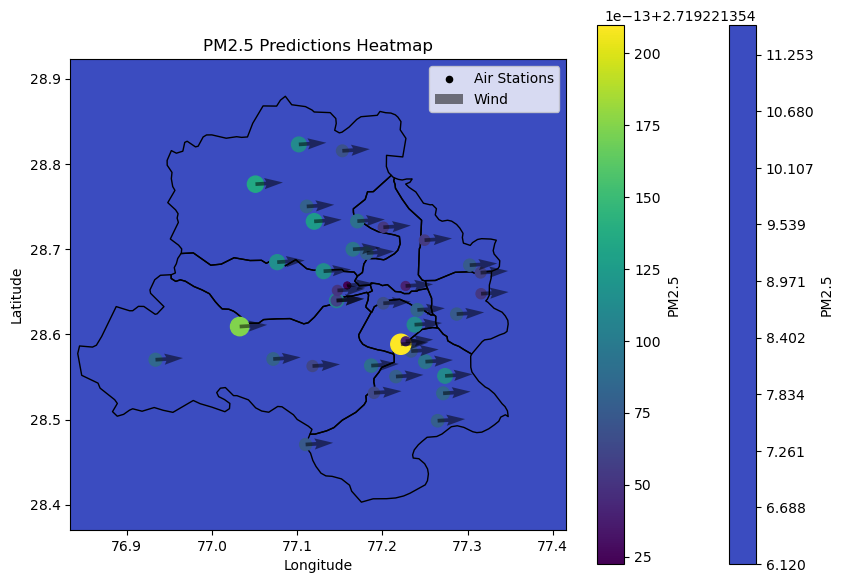

In [29]:
heatmap(longitudes = np.array(test['longitude']), latitudes = np.array(test['latitude']), values = test['PM2.5'].values, df = df)

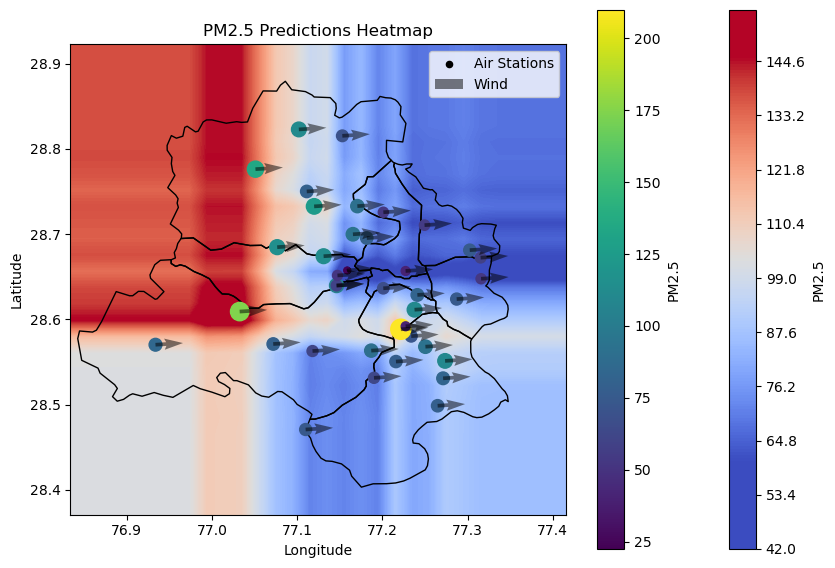

In [30]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
X_train = df[['latitude', 'longitude', 'WS', 'WD']]
y_train = df['PM2.5']
X_test = test[['latitude', 'longitude', 'WS', 'WD']]
rf.fit(X_train, y_train)
test['RF_PM2.5'] = rf.predict(X_test)
heatmap(longitudes = np.array(test['longitude']), latitudes = np.array(test['latitude']), values = test['RF_PM2.5'].values, df = df)

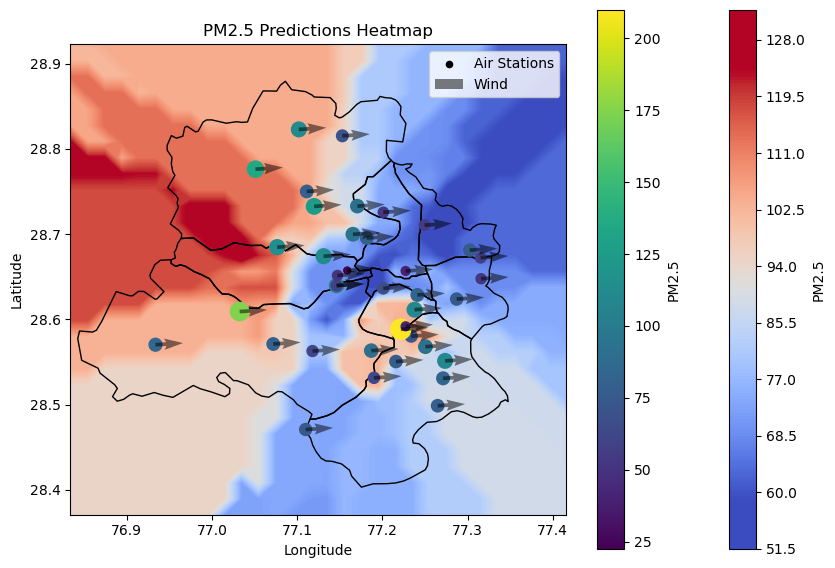

In [31]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()
X_train = df[['latitude', 'longitude', 'WS', 'WD']]
y_train = df['PM2.5']
X_test = test[['latitude', 'longitude', 'WS', 'WD']]
knn.fit(X_train, y_train)
test['KNN_PM2.5'] = knn.predict(X_test)
heatmap(longitudes = np.array(test['longitude']), latitudes = np.array(test['latitude']), values = test['KNN_PM2.5'].values, df = df)